In [2]:
# Standard Python Imports
import os
import json
import re
import string
import random
import time
import datetime
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace
from collections import Counter
from tqdm.notebook import tqdm
# import datasets

# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


# Hugging Face Imports
from transformers import BertTokenizer, BertForMaskedLM, BertConfig, AdamW, logging
from transformers import DataCollatorForLanguageModeling
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import pipeline
from transformers import EvalPrediction

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import math

In [3]:
logging.set_verbosity_error()

## Pre-Configuration 


In [4]:
args = Namespace(
    # model_save_path = "./models/mlm_model_manual1",
    model_save_path = "./models/base_mlm_test", # where to save model 
    data_filepath = './processed_data/sentences.csv', # path do training corpus (do not change)
    train_split = 0.7, # train split (val and test are split evenly among remaining samples)
    num_samples = 15000, # total number of samples 
    batch_size=16, 
    learn_rate=3e-5,
    epochs=5,
    device='cpu',
    patience=3, # patience of early stopping mechanism
    freeze=True # whether to freeze encoder weights or not 
)

In [5]:
# Load in data

raw_data_df = pd.read_csv(args.data_filepath)


raw_data_df['split'] = 'train'
num_train_rows = int(len(raw_data_df) * (1 - args.train_split)//2) - 1
raw_data_df.loc[:num_train_rows, 'split'] = 'val'
raw_data_df.loc[num_train_rows:num_train_rows + num_train_rows, 'split'] = 'test'
raw_data_df.head()

,Unnamed: 0,sentence,split
0,0,(c) Roth IRA's.--Paragraph (4) of section 408A...,val
1,1,"For example, the State Constitution provides t...",val
2,2,"See Capco of Summerville, Inc. v. J.H.",val
3,3,New York - Mother Terrorizing Family,val
4,4,at 701 (<HOLDING>); see also United Parcel Ser...,val


In [6]:
print('Number of train samples : ' + str((raw_data_df['split'] == 'train').sum()))
print('Number of val samples : ' + str((raw_data_df['split'] == 'val').sum()))
print('Number of test samples : ' + str((raw_data_df['split'] == 'test').sum()))

Number of train samples : 9986
Number of val samples : 2138
Number of test samples : 2139


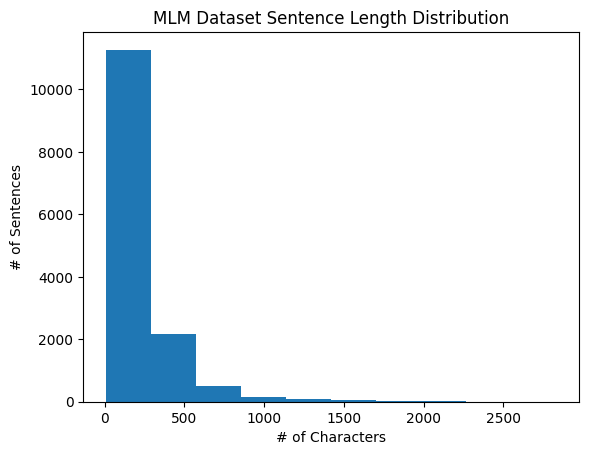

In [7]:
lengths = []
for index, row in raw_data_df.iterrows():
    lengths.append(len(row['sentence']))

plt.hist(lengths)
plt.xlabel('# of Characters')
plt.ylabel('# of Sentences')
plt.title('MLM Dataset Sentence Length Distribution')
plt.show()

In [8]:
tokenizer = BertTokenizer.from_pretrained('casehold/legalbert')

In [9]:
'''
    data collator will replace 15% of tokens with [MASK] token uniformly
'''
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [10]:
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [11]:
x = raw_data_df[raw_data_df['split'] == 'train']['sentence']
x.head()

4277    '';\n            (2) in section 16133(a) by in...
4278    Prohibits a Member from administering the oath...
4279    ``(2) Administration.--The land added as wilde...
4280    § 6323(a), leave which is never afforded to no...
4281    ``(f) Avoidance of Wildlife Impacts and Mitiga...
Name: sentence, dtype: object

### Prepare data splits 

In [12]:
encoded_data_train = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'train']['sentence'].tolist()]
dataloader_train = DataLoader(encoded_data_train, collate_fn=data_collator, batch_size=8)

encoded_data_val = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'val']['sentence'].tolist()]
dataloader_val = DataLoader(encoded_data_val, collate_fn=data_collator, batch_size=8)

encoded_data_test = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'test']['sentence'].tolist()]
dataloader_test = DataLoader(encoded_data_test, collate_fn=data_collator, batch_size=8)



In [13]:
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### Set up training

In [15]:
model = BertForMaskedLM.from_pretrained('casehold/legalbert')
# model = AutoModelForMaskedLM.from_pretrained("./models/sentence_pair_classification")

if args.freeze:
    for param in model.base_model.parameters():
        param.requires_grad  = False
        model.classifier = torch.nn.Linear(model.config.hidden_size, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=args.learn_rate)

if args.freeze:
    optimizer = AdamW(model.classifier.parameters(), lr=args.learn_rate)

num_train_steps = len(dataloader_train) * args.epochs
num_warmup_steps = num_train_steps * 0.1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

/home/jz75/Documents/2023-2024/SH-Project/CS4099-LegalNLP/pytorchenv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
train_progress = tqdm(total=0, desc='Train Batches', leave=True)
validation_progress = tqdm(total=0, desc='Validation Batches', leave=True)
epoch_progress = tqdm(total=args.epochs, desc='Epoch', leave=True)

best_val_accuracy = 0.0
patience = 3
num_epochs_no_improvement = 0

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
for epoch in range(args.epochs):

    total_train_loss = 0
    total_train_accuracy = 0

    train_progress.reset(total=len(dataloader_train))
    validation_progress.reset(total=len(dataloader_val))
    for step,batch in enumerate(dataloader_train):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        input_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_train_accuracy += calculate_accuracy(logits, labels)

        optimizer.step()
        scheduler.step()

        train_progress.update(1)

    avg_train_loss = total_train_loss/len(dataloader_train)
    print(f'Epoch {epoch}: Average Training Loss: {avg_train_loss}')
    
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dataloader_val:
        # Extract inputs, attention mask, and labels from batch
        input_ids = batch['input_ids'].to(device)
        input_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
        
        logits = outputs.logits.view(-1, outputs.logits.size(-1)) # raw predictions
        labels = labels.view(-1)
        loss = loss_fn(logits, labels)

        total_eval_loss += loss

        predicted_token_indices = torch.argmax(logits, dim=-1)
        mask = labels != -100
        relevant_labels = labels[mask]
        relevant_predictions = predicted_token_indices[mask]

        accuracy = (relevant_predictions == relevant_labels).float().mean().item()

        total_eval_accuracy += accuracy

        validation_progress.update(1)

    avg_val_accuracy = total_eval_accuracy/len(dataloader_val)
    print(f'Epoch {epoch}: Validation Accuracy: {avg_val_accuracy}')

    # Checkpointing and Early Stopping
    if avg_val_accuracy > best_val_accuracy:
        print(f'Validation accuracy improved from {best_val_accuracy} to {avg_val_accuracy}. Saving model...')
        best_val_accuracy = avg_val_accuracy
        num_epochs_no_improvement = 0
        # Save the model using save_pretrained
        model.save_pretrained(args.model_save_path)
        # Optionally save the tokenizer if it's being fine-tuned or used
        # tokenizer.save_pretrained(checkpoint_path)
    else:
        num_epochs_no_improvement += 1
        if num_epochs_no_improvement >= args.patience:
            print("Early stopping triggered.")
            break  # Exit the training loop

    epoch_progress.update(1)

        





Train Batches: 0it [00:00, ?it/s]

Validation Batches: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Average Training Loss: 1.9392219766843215
Epoch 0: Validation Accuracy: 0.6550313271026114
Validation accuracy improved from 0.0 to 0.6550313271026114. Saving model...
Epoch 1: Average Training Loss: 1.9426001813814486
Epoch 1: Validation Accuracy: 0.6529013129757412
Epoch 2: Average Training Loss: 1.9020520605451112
Epoch 2: Validation Accuracy: 0.6518240220733543
Epoch 3: Average Training Loss: 1.9107726063367556
Epoch 3: Validation Accuracy: 0.6469633390209568
Early stopping triggered.


In [14]:
model.save_pretrained(args.model_save_path)

## Testing + Evaluation

In [15]:
text1 = 'Yet they lie wholly outside the scope of Parliamentary [MASK].' #law

text2 = 'The opening words of section 3(1) of the 1934 Act provided that the 1923 Act was to apply for the purpose of enabling a person holding a [MASK] under this Act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.' # license

mlm_model = AutoModelForMaskedLM.from_pretrained(args.model_save_path)

pipeline_model = pipeline('fill-mask', model=mlm_model, tokenizer=tokenizer, top_k=10)

result = pipeline_model(text2)

for pred in result:
    print(f">>> {pred['sequence']}")

>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a licence under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a license under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a permit under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the

In [17]:
def evaluate_mlm_perplexity(model_path, title):
    '''
        Routine for evaluating model on test split 
    '''
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

    # Load model 
    test_model = AutoModelForMaskedLM.from_pretrained(model_path)

    # tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    
    test_model.to(device)

    test_model.eval()

    losses = []

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            input_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = test_model(input_ids, token_type_ids=None, attention_mask=input_mask)

            logits = outputs.logits.view(-1, outputs.logits.size(-1))
            labels = labels.view(-1)
            loss = loss_fn(logits, labels) 

            losses.append(loss.unsqueeze(0))

        
        losses = torch.cat(losses)
        try:
            perplexity = math.exp(torch.mean(losses))
        except OverflowError:
            perplexity = float('inf')
        print(title, f"Perplexity: {perplexity}")
        

            


In [18]:
def evaluate_mlm_accuracy(model_path, title, k=5):
    '''
        Routine for evaluating model on test split 
    '''

    # Load model 
    test_model = AutoModelForMaskedLM.from_pretrained(model_path)

    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    
    test_model.to(device)

    test_model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            input_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = test_model(input_ids, token_type_ids=None, attention_mask=input_mask)

            logits = outputs.logits

            # Get top-K predictions
            _, top_k_indices = torch.topk(logits, k, dim=-1)

            for i in range(input_ids.size(0)):  # Loop over batch
                for j in range(input_ids.size(1)):  # Loop over sequence length
                    if labels[i, j].item() != -100:  # Check if position is masked
                        if labels[i, j].item() in top_k_indices[i, j].tolist():
                            correct_predictions += 1
                        total_samples += 1


    top_k_accuracy = correct_predictions / total_samples
    print(title, 'Top', k, 'Accuracy :', top_k_accuracy)


In [18]:
print('Evaluation Metrics')
print('====================================')
evaluate_mlm_accuracy('bert-base-uncased',  "Bert Base Model", 5)
evaluate_mlm_accuracy(args.model_save_path,  "Fine Tuned Model MLM", 5)
# evaluate_mlm_accuracy("models/casehold_mlm",  "Fine Tuned Model MLM+SPC", 5)
evaluate_mlm_accuracy("casehold/legalbert",  "Casehold LegalBert", 5)
# evaluate_mlm_accuracy("./models/mlm_model",  "MLM Model1", 5)
evaluate_mlm_accuracy('./models/mlm_model_manual1', 'MLM Model Manual 1', 5)
print()
evaluate_mlm_accuracy('bert-base-uncased',  "Bert Base Model", 10)
evaluate_mlm_accuracy(args.model_save_path,  "Fine Tuned Model MLM", 10)
# evaluate_mlm_accuracy("models/casehold_mlm",  "Fine Tuned Model MLM+SPC", 10)
evaluate_mlm_accuracy("casehold/legalbert",  "Casehold LegalBert", 10)
# evaluate_mlm_accuracy("./models/mlm_model",  "MLM Model1", 10)
evaluate_mlm_accuracy('./models/mlm_model_manual1', 'MLM Model Manual 1', 10)
print()
evaluate_mlm_perplexity("bert-base-uncased", "Bert Base Model ")
evaluate_mlm_perplexity(args.model_save_path, "Fine Tuned Model MLM")
# evaluate_mlm_perplexity("models/casehold_mlm",  "Fine Tuned Model MLM+SPC")
evaluate_mlm_perplexity("casehold/legalbert",  "Casehold LegalBert")
# evaluate_mlm_perplexity("./models/mlm_model",  "MLM Model1")
evaluate_mlm_perplexity('./models/mlm_model_manual1', 'MLM Model Manual 1')
print()


Evaluation Metrics
Bert Base Model Top 5 Accuracy : 0.7430977663859392
Fine Tuned Model MLM Top 5 Accuracy : 0.8477336071585742
Casehold LegalBert Top 5 Accuracy : 0.8219657483246463
MLM Model Manual 1 Top 5 Accuracy : 0.8520215832655776

Bert Base Model Top 10 Accuracy : 0.7825666939139482
Fine Tuned Model MLM Top 10 Accuracy : 0.8862404395930794
Casehold LegalBert Top 10 Accuracy : 0.8620791932374314
MLM Model Manual 1 Top 10 Accuracy : 0.884466797871565

Bert Base Model  Perplexity: 13.020986658986075
Fine Tuned Model MLM Perplexity: 4.447846107050166
Casehold LegalBert Perplexity: 6.734102896920245
MLM Model Manual 1 Perplexity: 4.647554607166225



In [3]:
top_5_acc_data = {
    'Fine-Tuned Model' : 84.77,
    'bert-base-uncased' : 74.32,
    'casehold/legalbert' : 82.20,
    'Trigram Model' : 53.27 
}

top_10_acc_data = {
    'Fine-Tuned Model' : 88.62,
    'bert-base-uncased' : 78.26,
    'casehold/legalbert' : 86.20,
    'Trigram Model' : 55.56
}

perplex_data = {
    'Fine-Tuned Model' : 4.45,
    'bert-base-uncased' : 13.02,
    'casehold/legalbert' : 6.73
}

In [2]:
def bar_plot(data, xlabel, ylabel, title):
    plt.bar(data.keys(), data.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
bar_plot(top_5_acc_data, 'BERT Models')